In [1]:
import os
import sys
import numpy as np
import os.path as pa
from astropy.table import Table
from scipy.interpolate import interp1d
from snlstm.SpecProc import HomogenizeSpec
from snlstm.PhaseEstimate import FitSingleSpecPhase

import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import tensorflow
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)
from tensorflow.keras.models import load_model

#R_PATH = '/path/to/your/R-programming'
PATH_R = '/usr/bin/R'         # FIXME
assert pa.exists(PATH_R)

#SNDir = '/path/to/your/directory/of/sn2016coj'
SNDir = '/home/thomas/Lpackages/snlstm-extra/sn2016coj'
assert pa.exists(SNDir)

#MODEL_PATH = '/path/to/the/lstm/model'  # Note: the default model file BiLSTM4ST.h5 can be found on Github
MODEL_PATH = '/home/thomas/Lpackages/snlstm-extra/BiLSTM4ST.h5'
assert pa.exists(MODEL_PATH)


### Estimate Spectral Phases for the spectra of SN 2016coj (Assume the maximum time is unknown)
- SN 2016coj is a well-observed SN Ia in the latest BSNIP data release (Bibcode: 2020MNRAS.492.4325S).
- No spectroscopic data was included in our archival dataset, namely, it is a new SN for our predictive model.
- This example is to test the predictive performance of our model on estimating spectral phases.

In [2]:
# ** Basic information abour SN 2016coj
redshift = 0.0045     # redshift of SN 2016coj
MJD_Bmax = 57547.83   # MJD time of B maximum, estimated from phases given in the BSNIP paper

# ** Make a dictionary from phase to filepath for each raw spectrum of SN 2016coj
FilePath_dict = {-11.4: SNDir+'/sn2016coj-20160528.350-ui.csv',
                 -10.6: SNDir+'/sn2016coj-20160529.205-ui.csv',
                 -9.5: SNDir+'/sn2016coj-20160530.257-ui.csv',
                 -7.6: SNDir+'/sn2016coj-20160601.220-ui.csv',
                 -4.6: SNDir+'/sn2016coj-20160604.234-ui.csv',
                 -3.6: SNDir+'/sn2016coj-20160605.193-ui.csv',
                 -1.5: SNDir+'/sn2016coj-20160607.341-ui.csv',
                 -0.5: SNDir+'/sn2016coj-20160608.353-ui.csv',
                 +1.4: SNDir+'/sn2016coj-20160610.245-ui.csv',  # LSTM input spectrum
                 +6.4: SNDir+'/sn2016coj-20160615.226-ui.csv',
                 +7.5: SNDir+'/sn2016coj-20160616.333-ui.csv',
                 +8.4: SNDir+'/sn2016coj-20160617.248-ui.csv',
                 +15.3: SNDir+'/sn2016coj-20160624.244-ui.csv',
                 +16.3: SNDir+'/sn2016coj-20160625.227-ui.csv',
                 +18.3: SNDir+'/sn2016coj-20160627.223-ui.csv',
                 +19.4: SNDir+'/sn2016coj-20160628.306-ui.csv'}


In [106]:
# ** Process the raw spectral data before feeding into neural network
#    Homogenize the spectrum, using the module snlstm.SpecProc.HomogenizeSpec

FeedSpecDICT = {}
for phase in FilePath_dict:
    AstSpec_Raw = Table.read(FilePath_dict[phase], format='ascii.csv')
    Wave_Raw, Flux_Raw = np.array(AstSpec_Raw['wavelength']), np.array(AstSpec_Raw['flux'])
    HomoSpec_dict = HomogenizeSpec.HS(Wave_Raw=Wave_Raw, Flux_Raw=Flux_Raw, deredshift=True, redshift=redshift)
    Wave_Homo, Flux_Homo = np.array(HomoSpec_dict['wavelength']), np.array(HomoSpec_dict['flux'])
    FeedSpecDICT[phase] = {'wavelength': Wave_Homo, 'flux': Flux_Homo}

# ** Estimate three spectra Pre-Max (-9.5d); Max (-0.5d); Post-Max (+8.4d)
#    Note: it is a little bit time-consuming ~7 min

lstm_model = load_model(MODEL_PATH)
FITRES_DICT = {}
for phase_real in [-9.5, -0.5, +6.4]:
    Wave_in = FeedSpecDICT[phase_real]['wavelength']
    Flux_in = FeedSpecDICT[phase_real]['flux']
    fitres = FitSingleSpecPhase.FSSP(Wave_in, Flux_in, lstm_model, PATH_R, num_forward_pass=64, FAKE_MAPE_ERROR=0.2)
    FITRES_DICT[phase_real] = fitres
    

### Figure: Show the predictive accuacy

In [91]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from astropy import visualization as vs
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rc('text', usetex=True)
%matplotlib nbagg

def plot_main(phase_real, time_label):
    
    PHA_HP, MAPE_HP, GPHA_HP, GMAPE_HP, eGMAPE_HP = FITRES_DICT[phase_real] 
    phase_best_fit = GPHA_HP[np.argmin(GMAPE_HP)]
    
    fig = plt.figure(figsize=(8.5, 4))
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    fig.subplots_adjust(hspace=0.0, wspace=0.0, left=0.12, right=0.9, bottom=0.15, top=0.95)

    ax = plt.subplot(111)
    ax.scatter(PHA_HP, MAPE_HP, s=20.0, color='#F23814', marker='x')
    ax.plot(GPHA_HP, GMAPE_HP, color='black', linewidth=1.0)
    ax.fill_between(GPHA_HP, GMAPE_HP-2*eGMAPE_HP, GMAPE_HP+2*eGMAPE_HP, color='gray', alpha=0.2)
    
    TOP = np.max(GMAPE_HP)
    ax.vlines(x=[phase_real], ymin=2.0, ymax=0.5*TOP, color='#0099E6', linewidth=1.5, \
              linestyle='--', label=r'\textbf{Real-Phase = %.1fd}' %phase_real)
    ax.vlines(x=[phase_best_fit], ymin=2.0, ymax=0.5*TOP, color='black', linewidth=1.5, \
              linestyle='dotted', label=r'\textbf{Best-Fit-Phase = %.1fd}' %phase_best_fit)
    
    ax.annotate(r'\textbf{%s}' %time_label, xy=(-15.0, 0.97*TOP), fontsize=14.0, color='black')
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_major_locator(MultipleLocator(3.0))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(2.0))

    ax.set_xlabel(r'\textbf{Phase (day)}', fontsize=14)
    ax.set_ylabel(r'\textbf{Prediction MAPE ($\%$)}', fontsize=14)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)

    plt.legend(loc=4, borderpad=1.0, frameon=False, fontsize=11.5)
    plt.show()


<IPython.core.display.Javascript object>


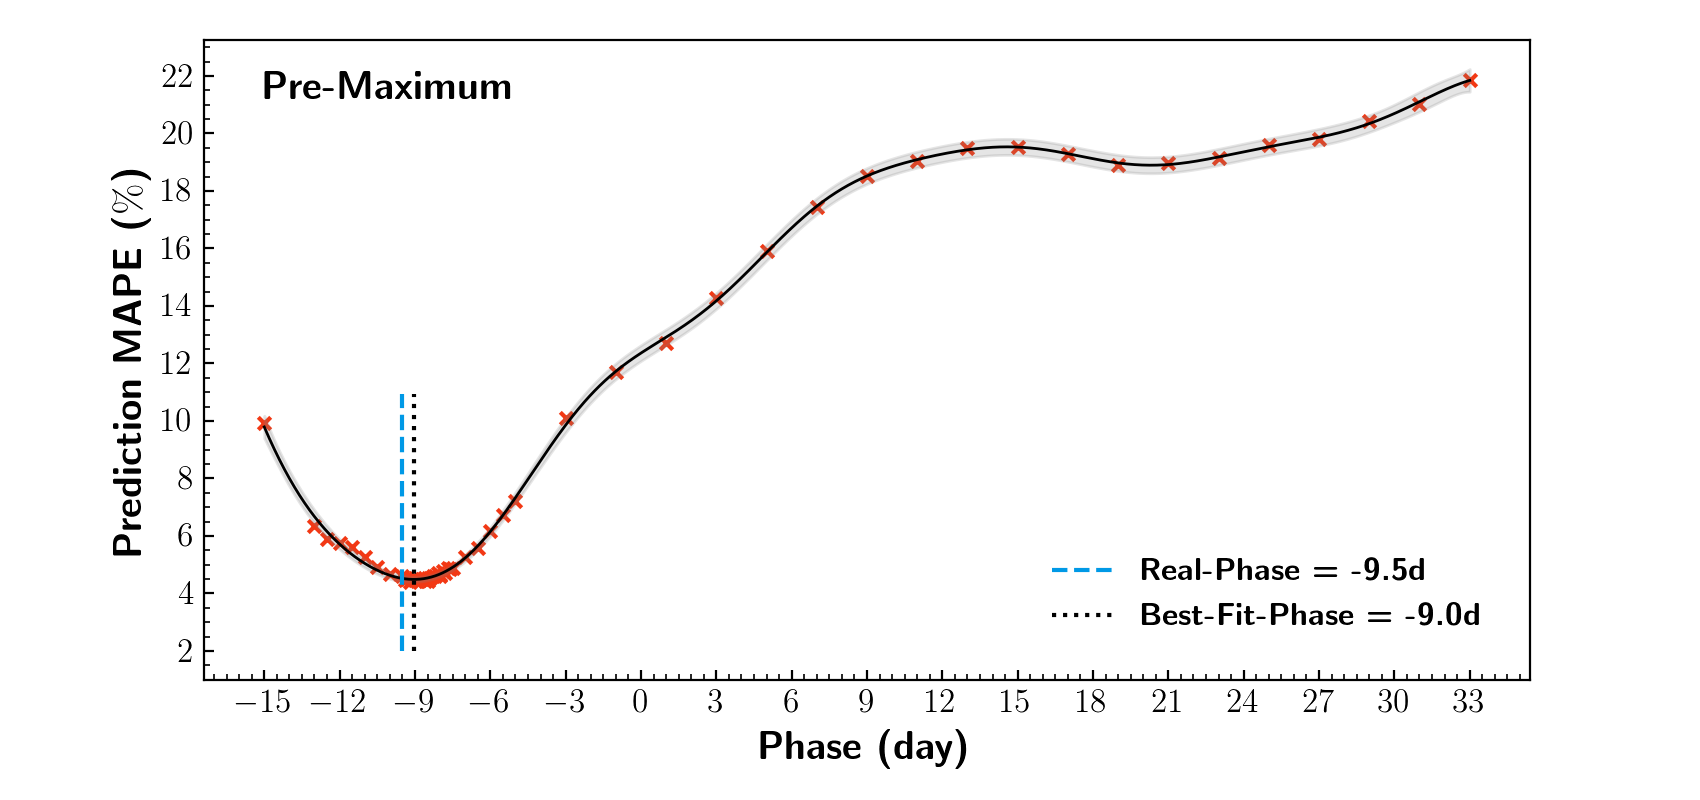

In [92]:
# ** Pre-maximum
plot_main(-9.5, 'Pre-Maximum')

<IPython.core.display.Javascript object>


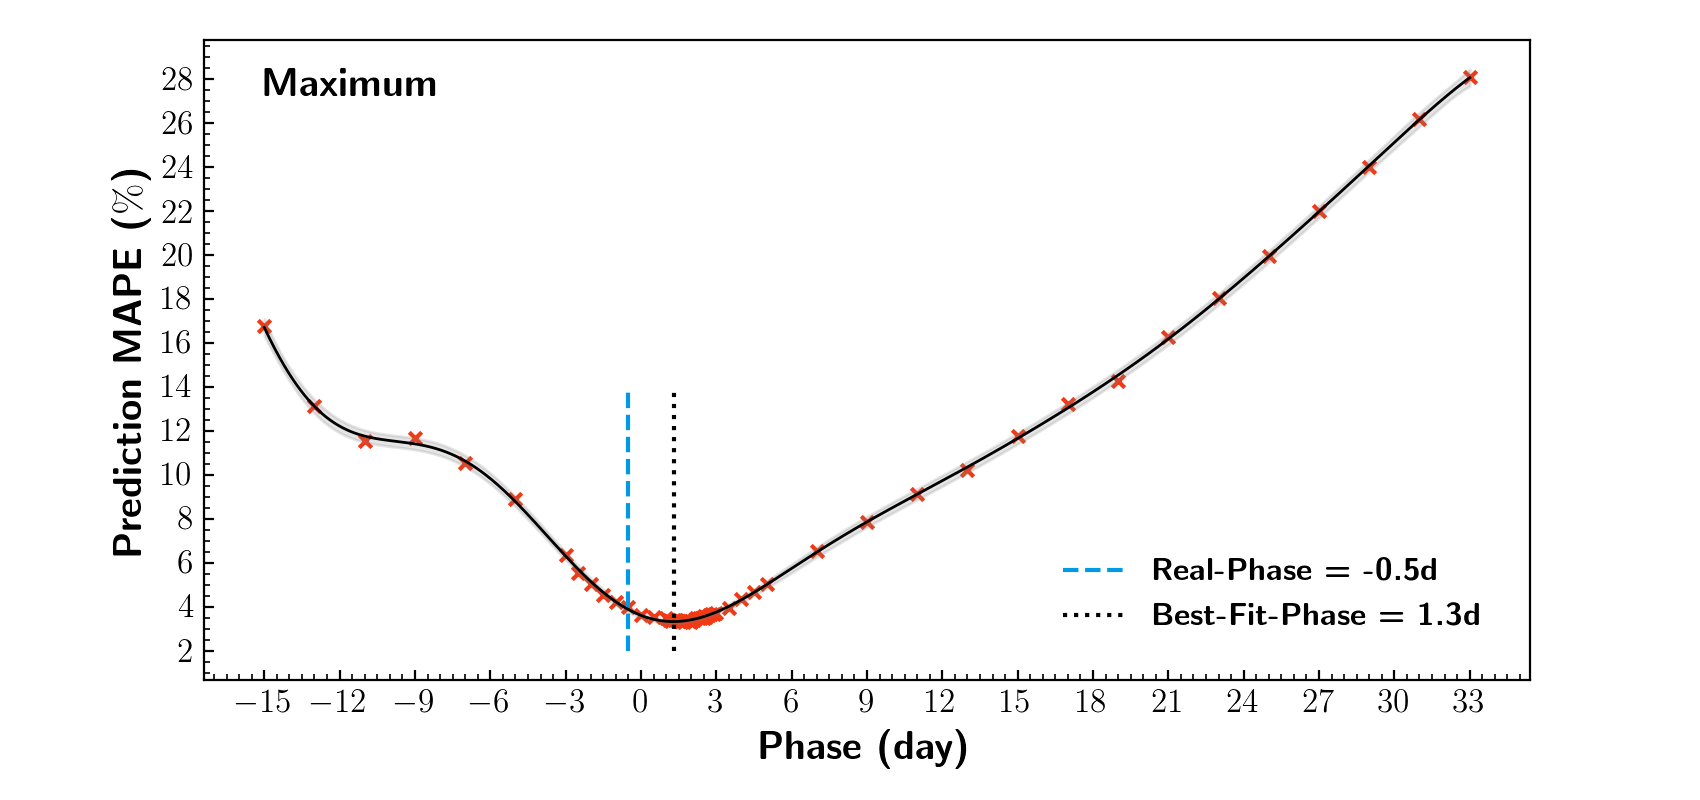

In [93]:
# ** Maximum
plot_main(-0.5, 'Maximum')

<IPython.core.display.Javascript object>


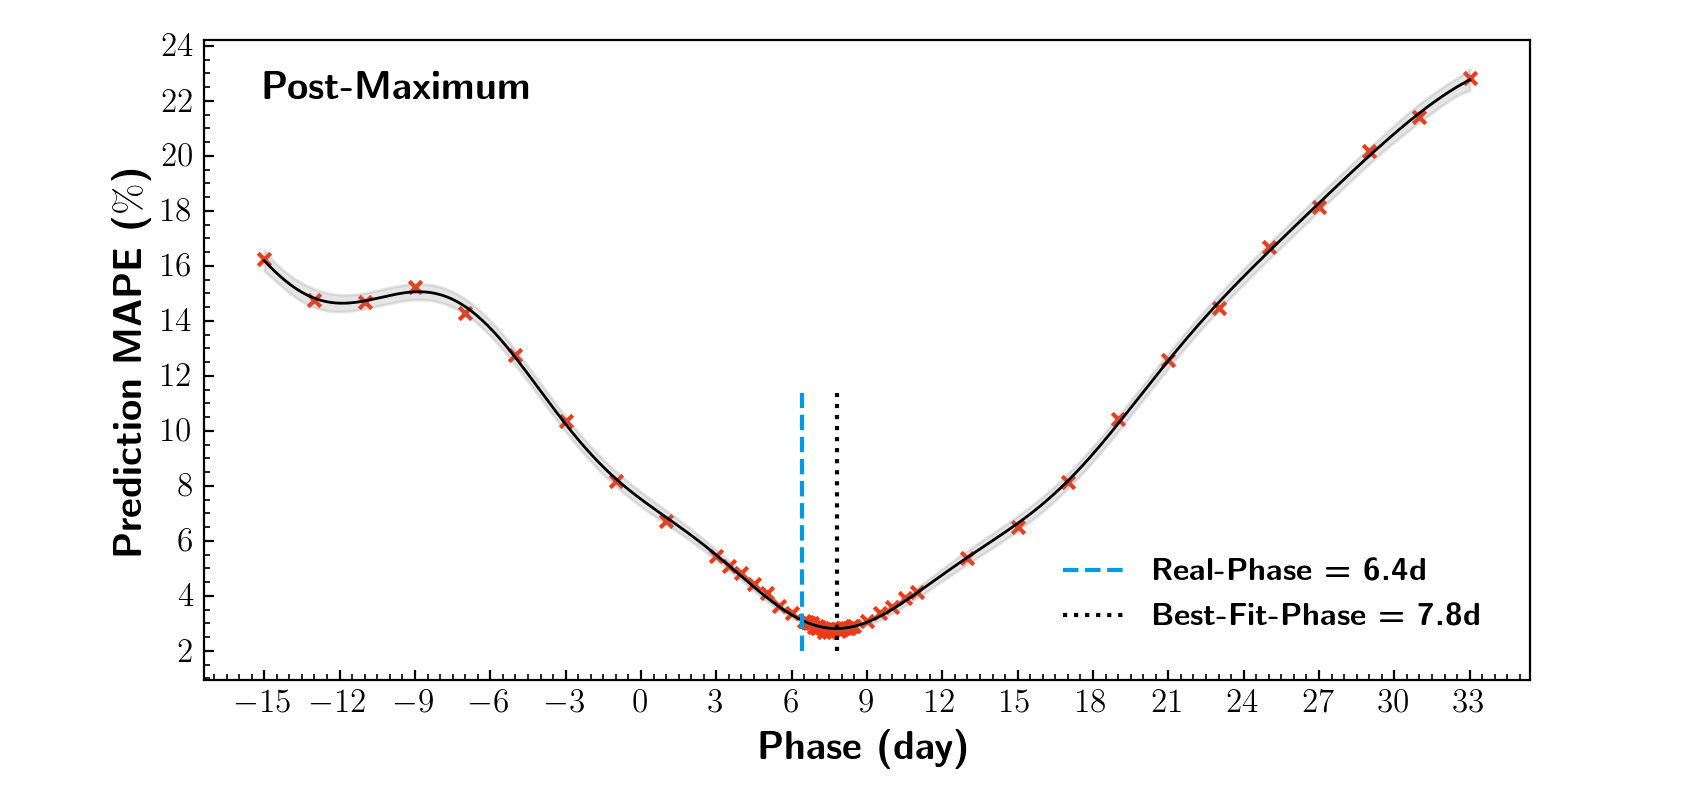

In [109]:
# ** Post-Maximum
plot_main(+6.4, 'Post-Maximum')